##  Depth Gap Analysis

**Hypothesis:** The paper notes that CNTK performance degrades or plateaus as depth increases, unlike finite CNNs.

**Experiment:** Run CNTK-GAP for a range of depths and plot the accuracy curve.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import TDL
from TDL.data import data_loader
from TDL.models import CNTK
from TDL.metrics import metrics
from TDL.estimation import estimation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# Define train and test sizes
n_train = 200
n_test = 100

X_train, Y_train, X_test, Y_test, y_test_labels = data_loader.load_cifar10(n_train=n_train, n_test=n_test)

Data loaded: Train torch.Size([200, 3, 32, 32]), Test torch.Size([100, 3, 32, 32])
Label range: [-0.1000, 0.9000]


In [ ]:
# Depth analysis experiment (reduced set of depths for time efficiency)
depths_to_test = [3, 4, 6, 11, 21]
depth_results = {'GAP': {}, 'Vanilla': {}}

print("Running Depth Gap Analysis...")
for depth in depths_to_test:
    # CNTK-GAP
    acc_gap, _ = estimation.run_experiment(X_train, Y_train, X_test, y_test_labels, depth=depth, use_gap=True)
    depth_results['GAP'][depth] = acc_gap
    
    # CNTK-V
    acc_v, _ = estimation.run_experiment(X_train, Y_train, X_test, y_test_labels, depth=depth, use_gap=False)
    depth_results['Vanilla'][depth] = acc_v

print("Depth analysis complete.")

Running Depth Gap Analysis...

Running: Depth=3, GAP=True
Computing training kernel...


Computing kernel: 100%|██████████| 20100/20100 [02:31<00:00, 132.48it/s]


Computing test kernel...


Computing kernel: 100%|██████████| 20000/20000 [02:38<00:00, 126.12it/s]


Kernel computation time: 310.61s
Accuracy: 35.00%

Running: Depth=3, GAP=False
Computing training kernel...


Computing kernel: 100%|██████████| 20100/20100 [03:16<00:00, 102.05it/s]


Computing test kernel...


Computing kernel: 100%|██████████| 20000/20000 [04:19<00:00, 77.15it/s] 


Kernel computation time: 456.19s
Accuracy: 24.00%

Running: Depth=4, GAP=True
Computing training kernel...


Computing kernel:  17%|█▋        | 3463/20100 [00:51<04:14, 65.45it/s]

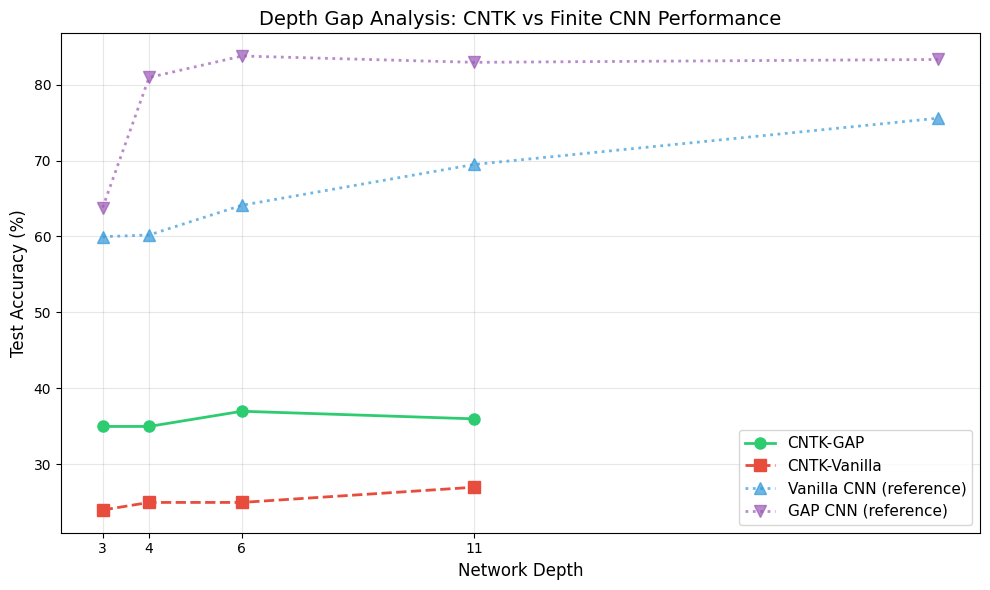

In [ ]:
# Plot depth analysis results
fig, ax = plt.subplots(figsize=(10, 6))

depths = list(depth_results['GAP'].keys())
gap_accs = list(depth_results['GAP'].values())
vanilla_accs = list(depth_results['Vanilla'].values())

ax.plot(depths, gap_accs, 'o-', linewidth=2, markersize=8, label='CNTK-GAP (N=200)', color='#2ecc71')
ax.plot(depths, vanilla_accs, 's--', linewidth=2, markersize=8, label='CNTK-Vanilla (N=200)', color='#e74c3c')

# Add reference lines
cnn_v_ref = {
    3: 59.97,
    4: 60.20,
    6: 64.11,
    11: 69.48,
    21: 75.57
}

cnn_gap_ref = {
    3: 63.81,
    4: 80.93,
    6: 83.75,
    11: 82.92,
    21: 83.30
}

cntk_v_ref = {
    3: 64.47,
    4: 65.52,
    6: 66.03,
    11: 65.90,
    21: 64.09
}

cntk_gap_ref = {
    3: 70.47,
    4: 75.93,
    6: 76.73,
    11: 77.43,
    21: 77.08
}

ref_depths = list(cnn_v_ref.keys())
ref_accs = list(cnn_v_ref.values())
ax.plot(ref_depths, ref_accs, '^:', linewidth=2, markersize=8, label='Vanilla CNN (reference)', color='#3498db', alpha=0.7)

ref_depths = list(cnn_gap_ref.keys())
ref_accs = list(cnn_gap_ref.values())
ax.plot(ref_depths, ref_accs, 'v:', linewidth=2, markersize=8, label='GAP CNN (reference)', color='#9b59b6', alpha=0.7)

ref_depths = list(cntk_v_ref.keys())
ref_accs = list(cntk_v_ref.values())
ax.plot(ref_depths, ref_accs, 'x--', linewidth=2, markersize=8, label='Vanilla CNTK (reference)', color='#f39c12', alpha=0.7)

ref_depths = list(cntk_gap_ref.keys())
ref_accs = list(cntk_gap_ref.values())
ax.plot(ref_depths, ref_accs, 'D--', linewidth=2, markersize=8, label='GAP CNTK (reference)', color='#d35400', alpha=0.7)

ax.set_xlabel('Network Depth', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Depth Gap Analysis: CNTK vs Finite CNN Performance', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(depths)

plt.tight_layout()
plt.savefig('../results/extension/depth_gap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
print("Depth Gap Analysis Results:")
print("="*70)
print(f"{'Depth':<10} {'CNTK-GAP':<15} {'CNTK-Vanilla':<15} {'Gap (GAP-V)':<15}")
print("-"*70)

for depth in depths:
    gap = depth_results['GAP'].get(depth, 0)
    vanilla = depth_results['Vanilla'].get(depth, 0)
    diff = gap - vanilla
    print(f"{depth:<10} {gap:.2f}%{'':<9} {vanilla:.2f}%{'':<9} {diff:+.2f}%")

print("="*70)

Depth Gap Analysis Results:
Depth      CNTK-GAP        CNTK-Vanilla    Gap (GAP-V)    
----------------------------------------------------------------------
3          35.00%          24.00%          +11.00%
4          35.00%          25.00%          +10.00%
6          37.00%          25.00%          +12.00%
11         36.00%          27.00%          +9.00%
